# Multilevel Quasi-Monte Carlo Comparison

## Setup

In [1]:
import fastgps
import qmcpy as qp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot

In [2]:
device = "cpu"
if device!="mps":
    torch.set_default_dtype(torch.float64)

In [3]:
colors = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]
_alpha = 0.25
WIDTH = 2*(500/72)
LINEWIDTH = 3
MARKERSIZE = 100

## Problem

In [4]:
levels = 4
n = np.array([2**14,2**12,2**10,2**8])
r = 8
n_r = n//r
d_coarsest = 4
f = qp.FinancialOption(
    sampler = qp.IIDStdUniform(dimension=d_coarsest),
    option = "ASIAN",
    call_put = "CALL",
    asian_mean = "GEOMETRIC",
    asian_mean_quadrature_rule = "RIGHT",
    volatility = .5,
    start_price = 39,
    strike_price = 40,
    interest_rate = 0.05,
    t_final = 1, 
    level = 0,
    d_coarsest = d_coarsest,
)
fs = [f]+f.spawn([l for l in range(1,levels)])
d = [fs[l].d for l in range(levels)]
exact_value_inf_dim = f.get_exact_value_inf_dim()
exact_values = np.array([fs[l].get_exact_value() for l in range(levels)])
for l in range(levels):
    print("l = %-7d d[l] = %-7d n[l] = %-7d n_r[l] = %-7d exact_values[l] = %-10.4f exact_value_inf_dim = %-10.4f"%(l,d[l],n[l],n_r[l],exact_values[l],exact_value_inf_dim))

l = 0       d[l] = 4       n[l] = 16384   n_r[l] = 2048    exact_values[l] = 4.8832     exact_value_inf_dim = 3.9344    
l = 1       d[l] = 8       n[l] = 4096    n_r[l] = 512     exact_values[l] = 4.4027     exact_value_inf_dim = 3.9344    
l = 2       d[l] = 16      n[l] = 1024    n_r[l] = 128     exact_values[l] = 4.1671     exact_value_inf_dim = 3.9344    
l = 3       d[l] = 32      n[l] = 256     n_r[l] = 32      exact_values[l] = 4.0504     exact_value_inf_dim = 3.9344    


## IID Monte Carlo

In [5]:
print("MLMC-IID")
print("~"*25)
iid_samplers = qp.IIDStdUniform(d[0],seed=7)
iid_samplers = [iid_samplers] + iid_samplers.spawn(s=levels-1,dimensions=d[1:])
mlmc_approx = 0
mlmc_std_error = 0
for l in range(levels):
    x = iid_samplers[l](n[l])
    y = fs[l].f(x)
    delta = y[1]-y[0]
    mlmc_approx_l = np.mean(delta)
    mlmc_approx += mlmc_approx_l
    mlmc_std_error_l = delta.std(ddof=1)/np.sqrt(n[l])
    mlmc_std_error = np.sqrt(mlmc_std_error**2+mlmc_std_error_l**2)
    mlmc_true_error = np.abs(mlmc_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f std_error_l = %-10.2e approx_l = %-10.4f  x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(mlmc_true_error,mlmc_std_error,mlmc_approx,mlmc_std_error_l,mlmc_approx_l,x.shape,y.shape,delta.shape))

MLMC-IID
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 8.94e-01   std_error = 7.16e-02   approx = 4.9449     std_error_l = 7.16e-02   approx_l = 4.9449      x.shape = (16384, 4)	y.shape = (2, 16384)	delta.shape = (16384,)  
error = 4.08e-01   std_error = 7.53e-02   approx = 4.4587     std_error_l = 2.30e-02   approx_l = -0.4861     x.shape = (4096, 8) 	y.shape = (2, 4096) 	delta.shape = (4096,)   
error = 1.94e-01   std_error = 7.83e-02   approx = 4.2440     std_error_l = 2.18e-02   approx_l = -0.2147     x.shape = (1024, 16)	y.shape = (2, 1024) 	delta.shape = (1024,)   
error = 6.30e-02   std_error = 8.18e-02   approx = 4.1134     std_error_l = 2.36e-02   approx_l = -0.1306     x.shape = (256, 32) 	y.shape = (2, 256)  	delta.shape = (256,)    


## QMC and MLQMC

### Lattice

In [6]:
print("MLQMC-Lattice")
print("~"*25)
lattice_samplers_mlqmc = qp.Lattice(d[0],replications=r,seed=7)
lattice_samplers_mlqmc = [lattice_samplers_mlqmc]+lattice_samplers_mlqmc.spawn(s=levels-1,dimensions=d[1:])
mlqmc_lattice_approx = 0 
mlqmc_lattice_std_error = 0 
for l in range(levels):
    x = lattice_samplers_mlqmc[l](n_r[l])
    y = fs[l].f(x)
    delta = y[1]-y[0]
    muhats = delta.mean(-1)
    mlqmc_lattice_approx_l = muhats.mean()
    mlqmc_lattice_approx += mlqmc_lattice_approx_l
    mlqmc_lattice_std_error_l = muhats.std(ddof=1)/np.sqrt(r)
    mlqmc_lattice_std_error = np.sqrt(mlqmc_lattice_std_error**2+mlqmc_lattice_std_error_l**2)
    mlqmc_lattice_true_error = np.abs(mlqmc_lattice_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f std_error_l = %-10.2e approx_l = %-10.4f  x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(mlqmc_lattice_true_error,mlqmc_lattice_std_error,mlqmc_lattice_approx,mlqmc_lattice_std_error_l,mlqmc_lattice_approx_l,x.shape,y.shape,delta.shape))

MLQMC-Lattice
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 8.37e-01   std_error = 6.05e-03   approx = 4.8873     std_error_l = 6.05e-03   approx_l = 4.8873      x.shape = (8, 2048, 4)	y.shape = (2, 8, 2048)	delta.shape = (8, 2048) 
error = 3.63e-01   std_error = 6.70e-03   approx = 4.4133     std_error_l = 2.87e-03   approx_l = -0.4740     x.shape = (8, 512, 8)	y.shape = (2, 8, 512)	delta.shape = (8, 512)  
error = 1.81e-01   std_error = 1.81e-02   approx = 4.2311     std_error_l = 1.68e-02   approx_l = -0.1822     x.shape = (8, 128, 16)	y.shape = (2, 8, 128)	delta.shape = (8, 128)  
error = 3.85e-02   std_error = 2.16e-02   approx = 4.0889     std_error_l = 1.19e-02   approx_l = -0.1422     x.shape = (8, 32, 32)	y.shape = (2, 8, 32)	delta.shape = (8, 32)   


### Net

In [7]:
print("MLQMC-Net")
print("~"*25)
net_samplers_mlqmc = qp.DigitalNet(d[0],replications=r,seed=7)
net_samplers_mlqmc = [net_samplers_mlqmc]+net_samplers_mlqmc.spawn(s=levels-1,dimensions=d[1:])
mlqmc_net_approx = 0 
mlqmc_net_std_error = 0 
for l in range(levels):
    x = net_samplers_mlqmc[l](n_r[l])
    y = fs[l].f(x)
    delta = y[1]-y[0]
    muhats = delta.mean(-1)
    mlqmc_net_approx_l = muhats.mean()
    mlqmc_net_approx += mlqmc_net_approx_l
    mlqmc_net_std_error_l = muhats.std(ddof=1)/np.sqrt(r)
    mlqmc_net_std_error = np.sqrt(mlqmc_net_std_error**2+mlqmc_net_std_error_l**2)
    mlqmc_net_true_error = np.abs(mlqmc_net_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f std_error_l = %-10.2e approx_l = %-10.4f  x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(mlqmc_net_true_error,mlqmc_net_std_error,mlqmc_net_approx,mlqmc_net_std_error_l,mlqmc_net_approx_l,x.shape,y.shape,delta.shape))

MLQMC-Net
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 8.32e-01   std_error = 1.32e-03   approx = 4.8820     std_error_l = 1.32e-03   approx_l = 4.8820      x.shape = (8, 2048, 4)	y.shape = (2, 8, 2048)	delta.shape = (8, 2048) 
error = 3.53e-01   std_error = 4.02e-03   approx = 4.4037     std_error_l = 3.79e-03   approx_l = -0.4782     x.shape = (8, 512, 8)	y.shape = (2, 8, 512)	delta.shape = (8, 512)  
error = 1.10e-01   std_error = 4.34e-03   approx = 4.1599     std_error_l = 1.63e-03   approx_l = -0.2438     x.shape = (8, 128, 16)	y.shape = (2, 8, 128)	delta.shape = (8, 128)  
error = 4.44e-03   std_error = 9.54e-03   approx = 4.0549     std_error_l = 8.50e-03   approx_l = -0.1051     x.shape = (8, 32, 32)	y.shape = (2, 8, 32)	delta.shape = (8, 32)   


## Fast Independent GPs

FIGPs-Lattice
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 8.34e-01   std_error = 7.63e-03   approx = 4.8847     std_error_l = 7.63e-03   approx_l = 4.8847      x.shape = (16384, 4)	y.shape = (2, 16384)	delta.shape = (16384,)  
error = 3.52e-01   std_error = 1.02e-02   approx = 4.4028     std_error_l = 6.71e-03   approx_l = -0.4819     x.shape = (4096, 8) 	y.shape = (2, 4096) 	delta.shape = (4096,)   
error = 1.24e-01   std_error = 1.36e-02   approx = 4.1742     std_error_l = 9.03e-03   approx_l = -0.2286     x.shape = (1024, 16)	y.shape = (2, 1024) 	delta.shape = (1024,)   
error = 6.67e-03   std_error = 2.77e-02   approx = 4.0437     std_error_l = 2.41e-02   approx_l = -0.1304     x.shape = (256, 32) 	y.shape = (2, 256)  	delta.shape = (256,)    


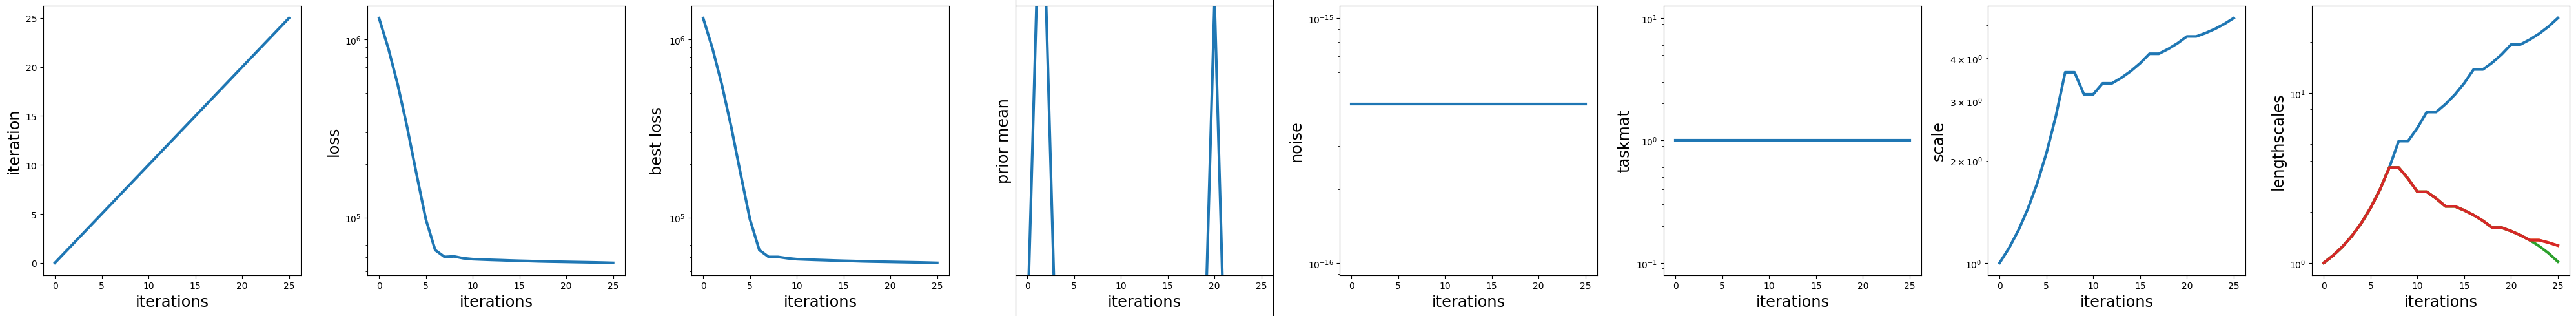

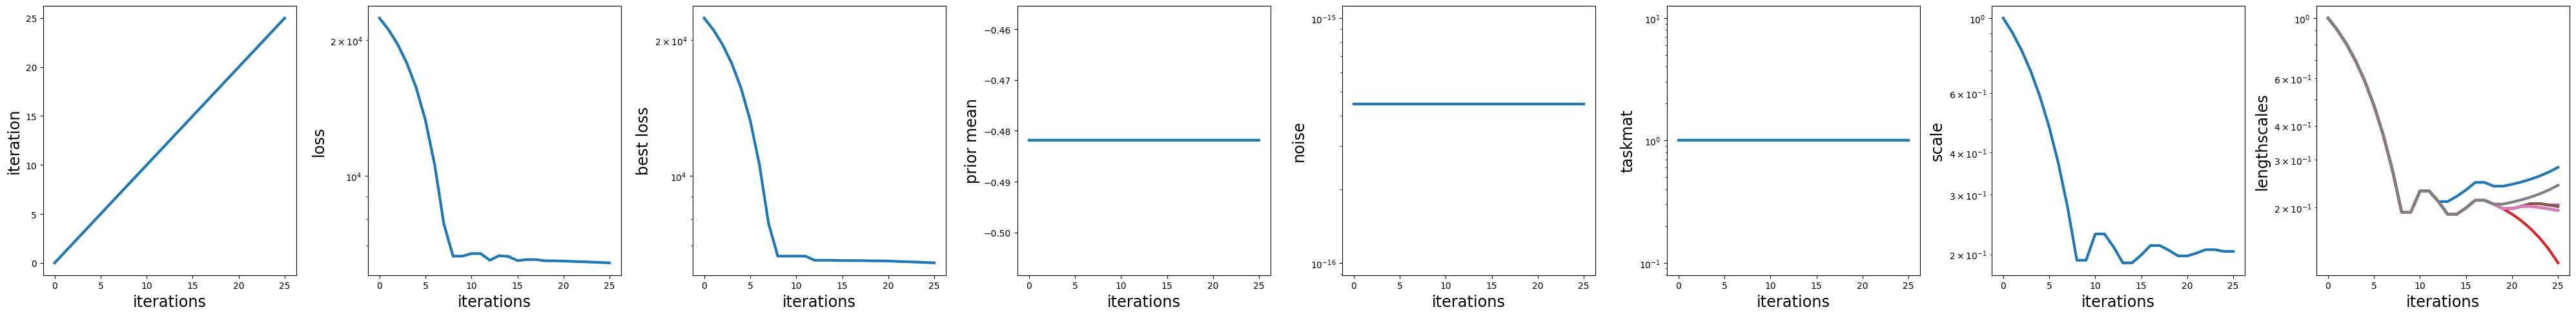

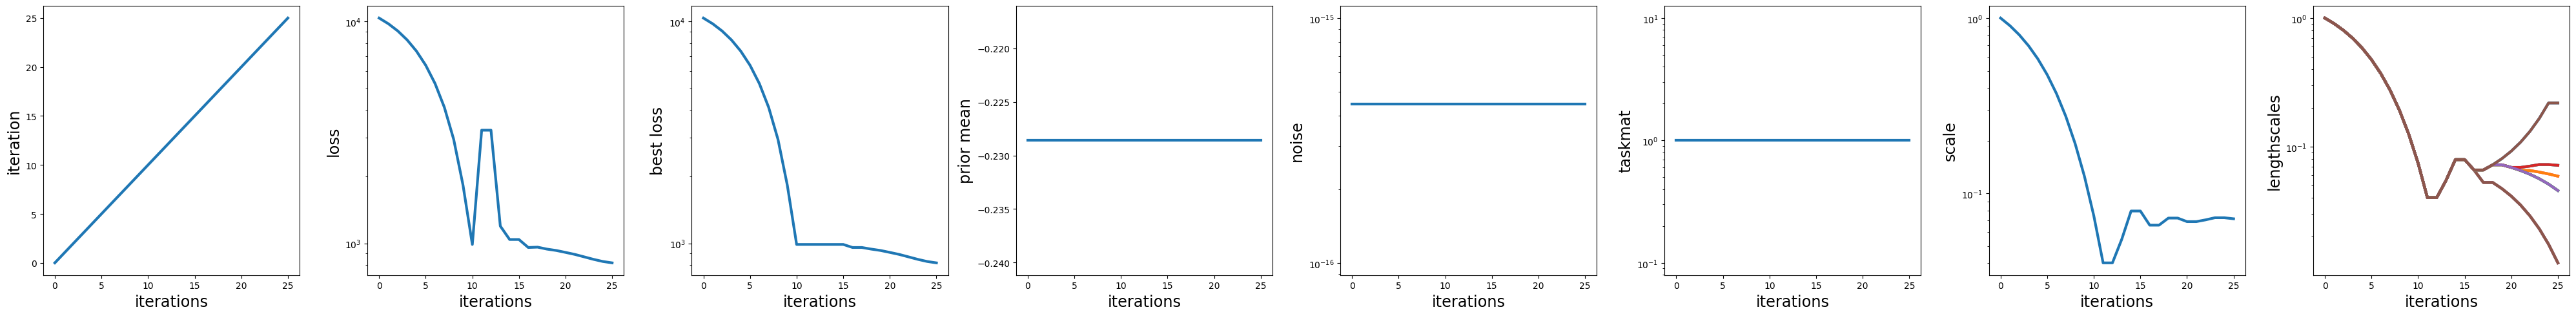

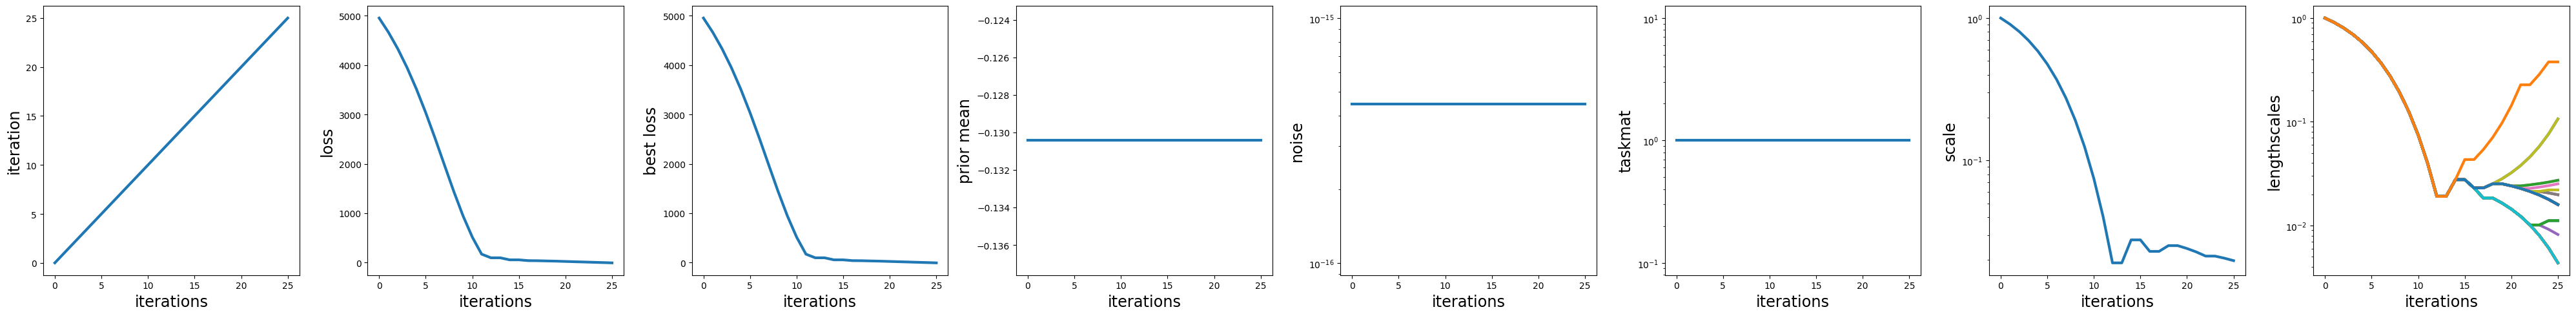

In [ ]:
print("FIGPs-Lattice")
print("~"*25)
lattice_samplers_figps = qp.Lattice(d[0],seed=7)
lattice_samplers_figps = [lattice_samplers_figps]+lattice_samplers_figps.spawn(s=levels-1,dimensions=d[1:])
figps_lattice = [
    fastgps.FastGPLattice(
        kernel = qp.KernelShiftInvar(
            d = d[l],
            torchify = True,
            alpha = 2,
        ),
        seqs = lattice_samplers_figps[l],
    )
    for l in range(levels)
]
figps_lattice_approx = 0 
figps_lattice_std_error = 0 
for l in range(levels):
    x = figps_lattice[l].get_x_next(n=n[l]).numpy()
    y = fs[l].f(x)
    delta = y[1]-y[0]
    figps_lattice[l].add_y_next(torch.from_numpy(delta))
    fit_data = figps_lattice[l].fit(
        loss_metric = "MLL",
        stop_crit_improvement_threshold = 1e-0,
        iterations = 25,
        store_hists = True,
        verbose = False,
    )
    fastgps.plot_fastgps_fit_data(fit_data)
    figps_lattice_approx_l = figps_lattice[l].post_cubature_mean().numpy()
    figps_lattice_approx += figps_lattice_approx_l
    figps_lattice_std_error_l = np.sqrt(figps_lattice[l].post_cubature_var().numpy())
    figps_lattice_std_error = np.sqrt(figps_lattice_std_error**2+figps_lattice_std_error_l**2)
    figps_lattice_true_error = np.abs(figps_lattice_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f std_error_l = %-10.2e approx_l = %-10.4f  x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(figps_lattice_true_error,figps_lattice_std_error,figps_lattice_approx,figps_lattice_std_error_l,figps_lattice_approx_l,x.shape,y.shape,delta.shape))

FIGPs-Net
~~~~~~~~~~~~~~~~~~~~~~~~~
error = 8.32e-01   std_error = 7.35e-04   approx = 4.8829     std_error_l = 7.35e-04   approx_l = 4.8829      x.shape = (16384, 4)	y.shape = (2, 16384)	delta.shape = (16384,)  
error = 3.52e-01   std_error = 1.59e-03   approx = 4.4028     std_error_l = 1.41e-03   approx_l = -0.4801     x.shape = (4096, 8) 	y.shape = (2, 4096) 	delta.shape = (4096,)   
error = 1.13e-01   std_error = 4.95e-03   approx = 4.1638     std_error_l = 4.69e-03   approx_l = -0.2390     x.shape = (1024, 16)	y.shape = (2, 1024) 	delta.shape = (1024,)   
error = 1.50e-03   std_error = 1.22e-02   approx = 4.0519     std_error_l = 1.11e-02   approx_l = -0.1119     x.shape = (256, 32) 	y.shape = (2, 256)  	delta.shape = (256,)    


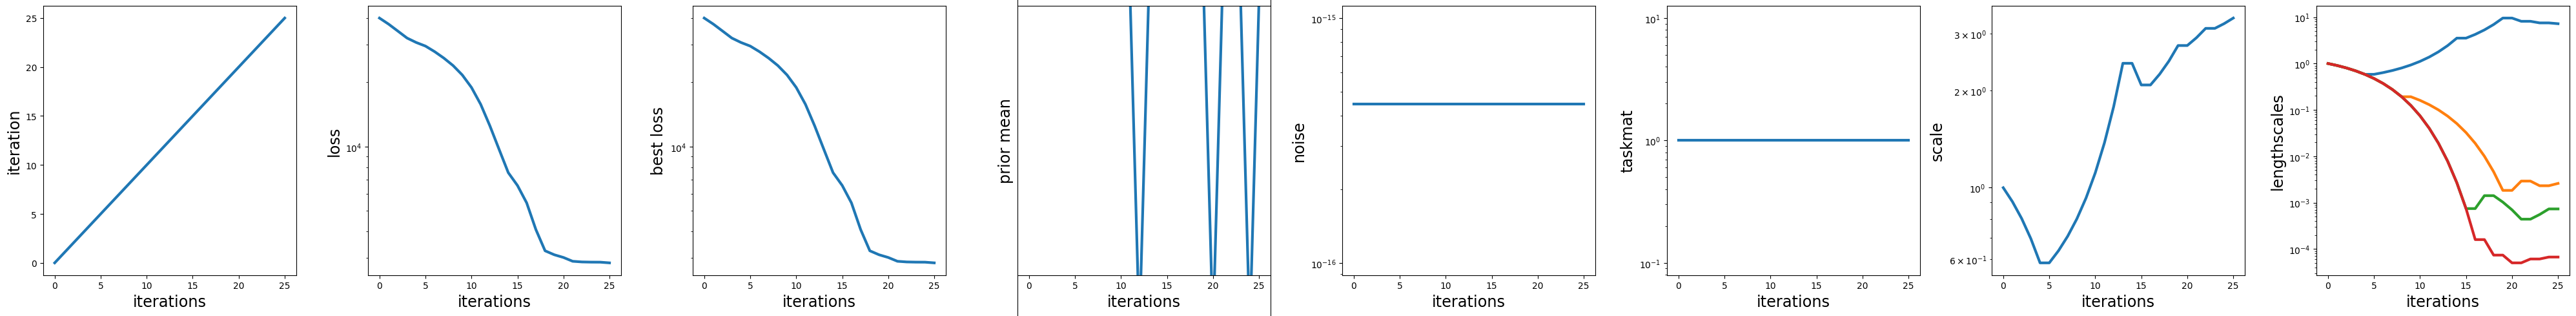

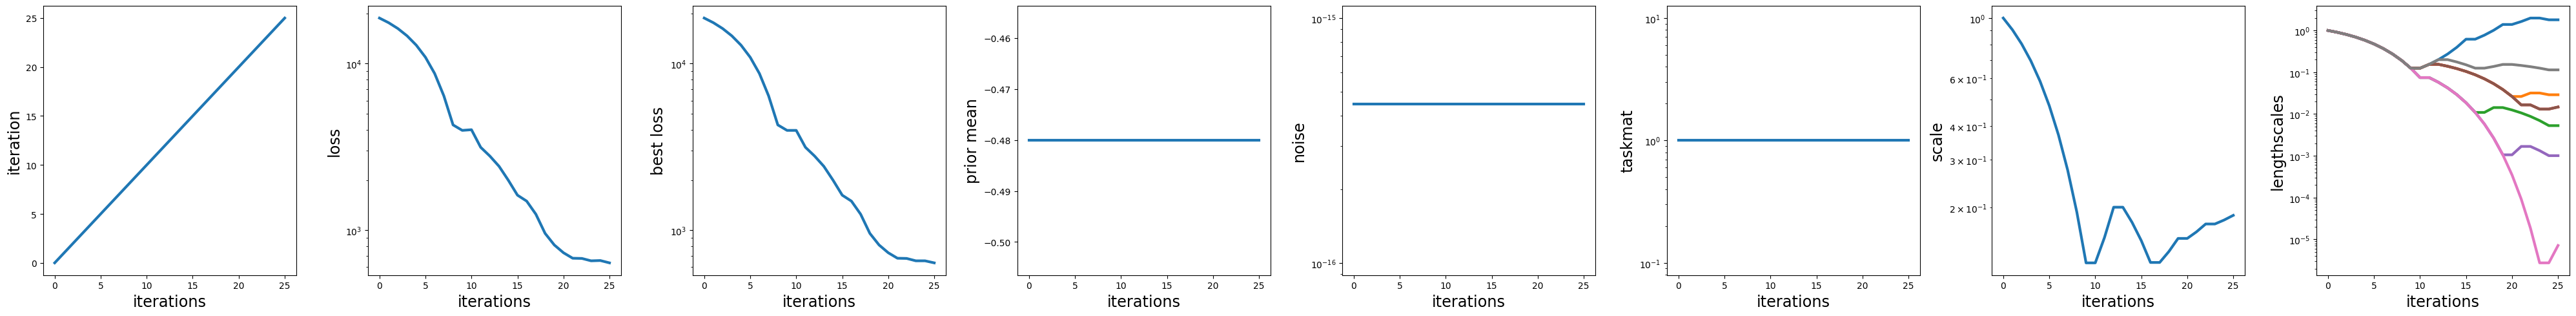

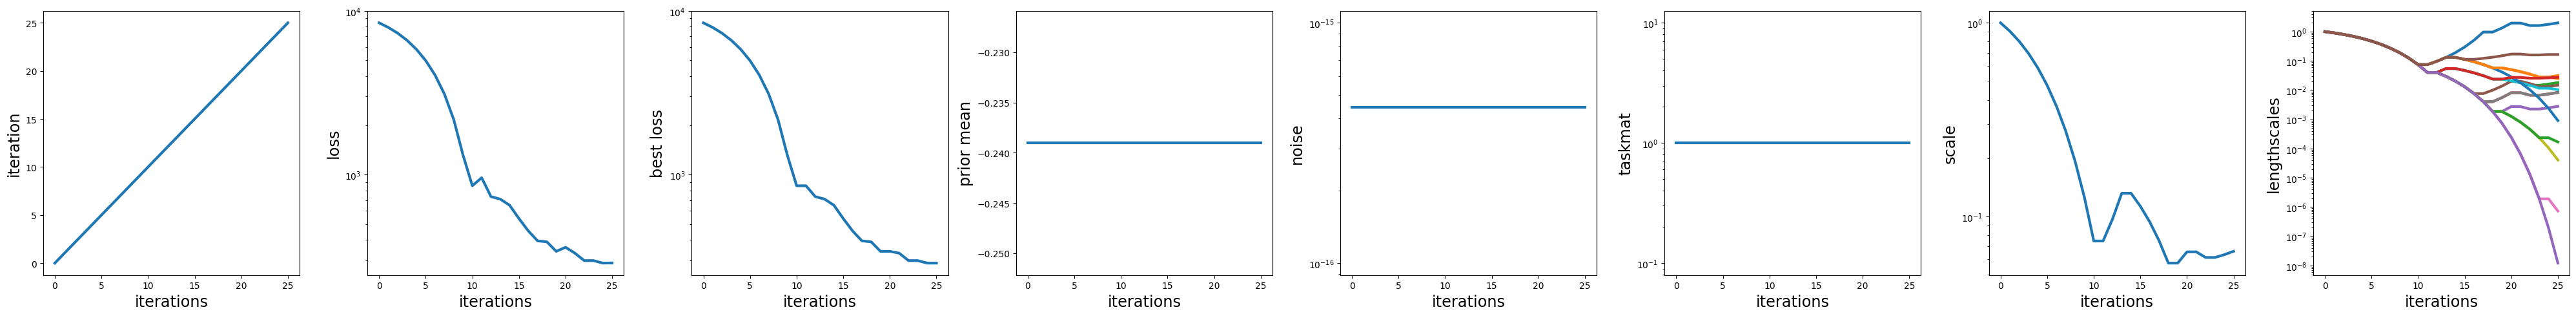

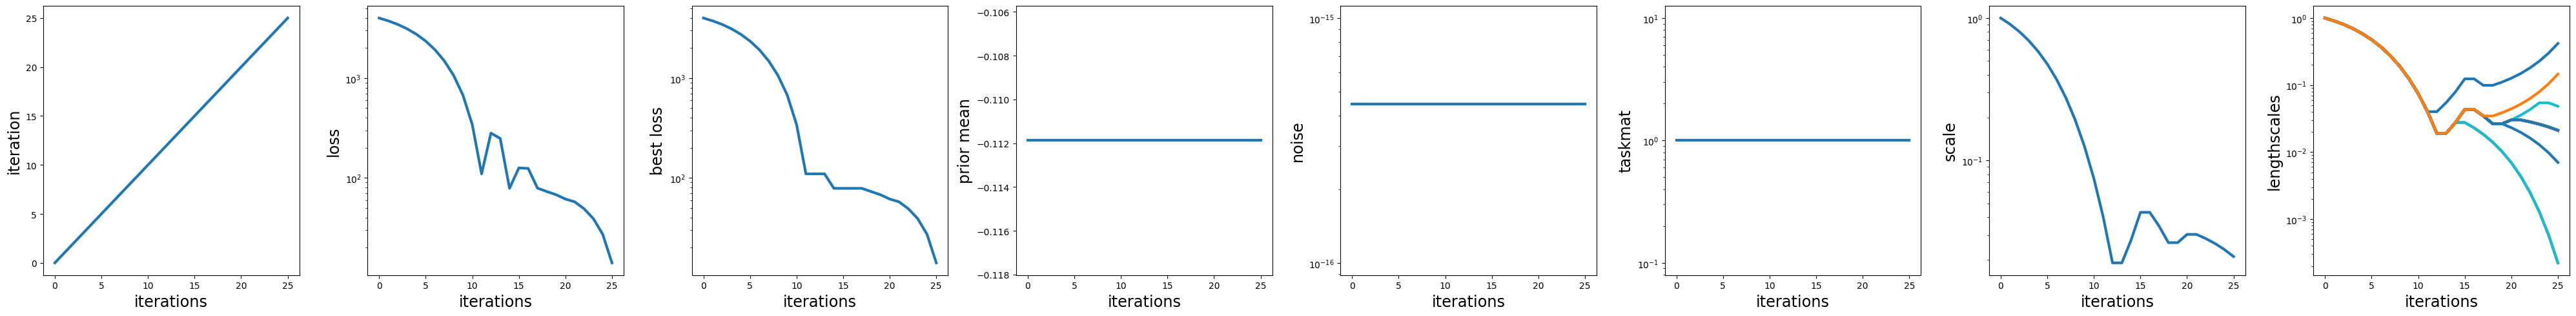

In [12]:
print("FIGPs-Net")
print("~"*25)
net_samplers_figps = qp.DigitalNet(d[0],seed=7)
net_samplers_figps = [net_samplers_figps]+net_samplers_figps.spawn(s=levels-1,dimensions=d[1:])
figps_net = [
    fastgps.FastGPDigitalNetB2(
        kernel = qp.KernelDigShiftInvar(
            d = d[l],
            torchify = True,
            alpha = 2
        ),
        seqs = net_samplers_figps[l],
    )
    for l in range(levels)
]
figps_net_approx = 0 
figps_net_std_error = 0 
for l in range(levels):
    x = figps_net[l].get_x_next(n=n[l]).numpy()
    y = fs[l].f(x)
    delta = y[1]-y[0]
    figps_net[l].add_y_next(torch.from_numpy(delta))
    fit_data = figps_net[l].fit(
        loss_metric = "MLL",
        stop_crit_improvement_threshold = 1e-0,
        iterations = 25,
        store_hists = True,
        verbose = False,
    )
    fastgps.plot_fastgps_fit_data(fit_data)
    figps_net_approx_l = figps_net[l].post_cubature_mean().numpy()
    figps_net_approx += figps_net_approx_l
    figps_net_std_error_l = np.sqrt(figps_net[l].post_cubature_var().numpy())
    figps_net_std_error = np.sqrt(figps_net_std_error**2+figps_net_std_error_l**2)
    figps_net_true_error = np.abs(figps_net_approx-exact_values[-1])
    print("error = %-10.2e std_error = %-10.2e approx = %-10.4f std_error_l = %-10.2e approx_l = %-10.4f  x.shape = %-10s\ty.shape = %-10s\tdelta.shape = %-10s"\
          %(figps_net_true_error,figps_net_std_error,figps_net_approx,figps_net_std_error_l,figps_net_approx_l,x.shape,y.shape,delta.shape))